# Mining Processes From Smart Contracts

In [1]:
from web3 import Web3 as web3
from web3 import Web3

In [10]:
w3 = Web3(Web3.WebsocketProvider("ws://127.0.0.1:8545", websocket_kwargs={'timeout': 60}))
w3.isConnected()

True

In [11]:
import pprint
pp = pprint.PrettyPrinter(indent=2)

In [12]:
events = {
    b"Created(bytes)": "",
    b"Started()": "",
    b"Finished(bytes)": "",
    b"TaskRequest(uint8,bytes)": "",
    b"TaskResponse(uint8,bytes)": "",
    b"SubChoreographyCreated(uint8,bytes,address)": "",
    b"SubChoreographyFinished(uint8,bytes,bool)": "",
    b"ThrewTrigger(uint8,bytes)": "",
    b"CaughtTrigger(uint8,bytes,address)": "",
    b"UncaughtTrigger(uint8,bytes,address)": "",
    b"ParticipantRegistered(address,uint8)": "",
    b"Interrupted()": "",
    b"Interrupting()": "",
    b"ChoreographyCreated(address,bytes)": "",
    b"DebugFlowExecuted(uint8)": "",
    b"DebugTokens(uint256)": ""
}

event_identifiers = {}

In [13]:
import sha3
for key in events.keys():
    event_hash = sha3.keccak_256()
    event_hash.update(key)
    hash_sum = event_hash.hexdigest()
    events[key] = hash_sum
    event_identifiers[hash_sum] = key
    
pp.pprint(events)

{ b'CaughtTrigger(uint8,bytes,address)': 'd003693c3439de61504dca10a93615eaefa8eca55b8799c5a085a2606df3c069',
  b'ChoreographyCreated(address,bytes)': '483bc8f670acc41b1a377626890eb8f1c05eab1ca1310cf4c2b4ffd48ccd7ce9',
  b'Created(bytes)': '3b4a808d54c495ced21b3f493818c8c5a90f41e600c8b12208571402dcd23cec',
  b'DebugFlowExecuted(uint8)': '4f9b468b3017530e918fd70bd401b56a83fcfe3762dc0fcb6f47a34714426d50',
  b'DebugTokens(uint256)': 'a22e2e8aa0764e8eb79b7a12b7ad10d07a677911e4f9d4528aff8a0b162800d5',
  b'Finished(bytes)': 'b71c75788c2fe89ea9323dcb43f8302b6b993d85e3c8107b79f07196b4e6c733',
  b'Interrupted()': '4df1c47c876258c784df017b6b8f6cca2918bc86bc77a4a4eb6035068f837e8e',
  b'Interrupting()': 'a4b03e4090fbd5b9934aecc73cead99e64d3172e14a76a086e732772746d7f6d',
  b'ParticipantRegistered(address,uint8)': '806d89d78ee0f826f9fa2e75e6e53e4a91ee0f70688d2152fd4d107423f3da63',
  b'Started()': 'd8cea0ecd56872ff072e771658b5682ffe4de16d752947f79597d600ea56f7a9',
  b'SubChoreographyCreated(uint8,byte

# first deployed contract from blockchain_etl
ROOT_CONTRACT_ADDRESS = w3.toChecksumAddress("0xcd23eCBBdBcC03aE1Bcf658Fd3893F2c6f87DeEf")
FACTORY_ADDRESS_A = "0x54497Da55F80B125a2050373fb7230e5A4eFA077"
FACTORY_ADDRESS_B = "0x7F79072c37A02e1F9474aa18Be0B4FeAA68cE624"
PARTICIPANTS_CONTAINER = "0xcd23eCBBdBcC03aE1Bcf658Fd3893F2c6f87DeEf"

root_contract_filter = w3.eth.filter({
    "fromBlock": "0x0",
    "toBlock": "latest",
    "address": ROOT_CONTRACT_ADDRESS
})
root_event_list = root_contract_filter.get_all_entries()

contract_events = []

for event in root_event_list:
    topic = event["topics"][0].hex()[2:]
    if topic in event_identifiers.keys():
        contract_events.append(event_identifiers[topic])
    else:
        contract_events.append(topic)
pp.pprint(contract_events)

In [14]:
from web3.utils.events import get_event_data
def get_events_for_contract(address):
    contract_filter = w3.eth.filter({
        "fromBlock": "0x0",
        "toBlock": "latest",
        "address": w3.toChecksumAddress(address)
    })
    event_list = contract_filter.get_all_entries()
    contract_events = []
    contract_transaction_events = []
    
    myLogs = w3.eth.getFilterLogs(contract_filter.filter_id)
    for event in event_list:
        trace_event = {}
        trace_event_attribute = {}
        block_number = event["blockNumber"]
        block = w3.eth.getBlock(block_number)
        block_time = block["timestamp"]
        trace_event["timestamp"] = block_time
        trace_event_attribute["timestamp"] = block_time
        
        topic = event["topics"][0].hex()[2:] # remove 0x from hex string
        if topic in event_identifiers.keys():
            trace_event["event"] = event_identifiers[topic]
            # event SubchoreographyCreated -> Address, add subchoreo events
            if event_identifiers[topic] == b'TaskRequest(uint8,bytes)':
                trace_event_attribute["event"]= event["data"][65:66]
                contract_transaction_events.append(trace_event_attribute)      
        else:
            trace_event["event"] = topic
        contract_events.append(trace_event)
    return(contract_events, contract_transaction_events)

In [15]:
# Contract addresses extracted w/ ethereum-etl
addresses = [
    "0x54497da55f80b125a2050373fb7230e5a4efa077",
    "0x7f79072c37a02e1f9474aa18be0b4feaa68ce624",
    "0xcd23ecbbdbcc03ae1bcf658fd3893f2c6f87deef",
    "0xac9de8da546a12587d1a135050a4bad03c9454a7",
    "0x985c0799c4e1d5df856ad8536a761ebc285e38da",
    "0x12126517e00d1658cfae45cb6ec3bdb23f2d7fee",
    "0x173eebf0087599ee2b2c26b0980bb2c3926fb213",
    "0x09eb457ed710b869f342b8887ae2201d165f03c5",
    "0x549b7f9a3f004f192a9775e1267ab6e0ef5b3a02",
    "0x1c71a360c98aee9b347b1ee22a4f0528ae2891be",
    "0xa65f710409afa8ae2bbe3703e5e7ba7924e9b678",
    "0xe355dc5beda5d9b3ff90a57ca25ea44c21c39a59",
    "0xb842518f16c9f5cc8bad2e207a0339211e48b6c8",
    "0x74f2170644de5637ec41ee73860bb332a936302e",
    "0x79d43cff7033bbf2106e26827b783f2f2b2f9924",
    "0x97a0ba2ba82abb04fbe80da3919a37fb8d1471fc",
    "0xc6af5b60104959a0ee25da0f499b079ad1cdc5aa",
    "0x0f46e37a9b1889fa0ff248d8a425bf8ee5190d9b",
    "0xee642fb45e9287dd4180dc9c6b855f5f98b72aa1",
    "0xac59e570330876cda6b4f0b74c63bee5c484cbcd",
    "0x92e6e66c57d2f72a7729b17c503397bd2ce39a14",
    "0x38736a9d62e8677da4b9d544e74c47c2dd555d8f",
    "0x7c847e665fc9b3a262ea70442a645edf81f2ded9",
    "0x1a09794e2aa64e44617fd5be93c013110b6e5cb2",
    "0xac4fc0474e53b5cdc11e86f11573eb3a39f83ba4",
    "0x4354e7cd384a739682c4f4965e1443c1a0199c26",
    "0x67c56bb418b131819a067ad922569af49031f26e",
    "0x2ce7e526a44b70bc8d4f8473eaa28b96b40d09e3",
    "0xae2d5b8088adca7722d60bbe45468fba4cdad9e3",
    "0xbfca45b31a0ea9cc5081693d2f7fe5675449a32c",
    "0x0b29f6a3a25738a963fbdf126a7279e393cb6699",
    "0xc2ed24bd410554a2419c5201063ad50ffef13354",
    "0xe516df8fd5d55b2bf311e19840aeb89fbfc4182f",
    "0xaac5270423ca6df6c709693d5b2a0cbc8d1a9acc",
    "0xf4401cace6efe3ee7f6b005d4163fa7d883e3acd",
    "0xabd883fe58425bd7ccec3287f4d36f1d291e8fbc",
    "0x76fa1baf78d2b05805c5e3d4dfa08073d45131f6",
    "0x45733739e78dc998e8b0012e7f6c3e66f1ec3b5f",
    "0x3a2516faa44c96eec910fd8234d4c8c1f6fc891c",
    "0x19fe432afda4a640268d61f066233369a0c28443",
    "0xb48bfbd80114f168ee09c6196a777600bdbae91d",
    "0x273c3f202d16ae19bc86e03b881a39effd70dfb0",
    "0xfddcb3db39345087e9579e94d3e3baa89c749a9f",
    "0x614c47782e17cdec596da3519d87aba979ec6f30",
    "0x15db36efb5885ef9ee0e58741123352d240ec340",
    "0x7498ff417f508c78917274b05b1b9ad6d0835fa9",
    "0x86279f768485d61eacbe2903fa35a9044c3c99ef",
    "0xba589199893528de8506e14e252043260e019074",
    "0x5a96556bd1b5659f7ee2c55450acf8ef0c725686",
    "0x1c3c7f949b93bdf774d8df0b2c0dbf29d1555a98",
    "0x457ab7594ba17c996282e87c9832e76d9a1c3644",
    "0xfc441d687c9b1996da1f780e21bd4dc5c4acb98a",
    "0x29c040896560141a9962f5a464be0c50999be495",
    "0x62a4b90872e0b8a9f7cb23ccdaebf52f45602eeb",
    "0x6406564ad50aee6591a610be6aedc468d8904797",
    "0xdb6d2884b8434a01a9e97d56919c25d835683999",
    "0xf06b61905935299c04e615a7c8fd078ee85fd579",
    "0x8b406644106c258cd04bd456530dc08c93df50c1",
    "0x37bd3669ef19a4db1b49686e12727dd833203d8c",
    "0xe35900d9f31891fb218fe0c15bf7cb24761372c0",
    "0xcdcc7023450eb3056da33479d8e8e312d27c0bb0",
    "0xefce392d4a8032bb807ae68875245631e9785160",
    "0x3b580a97a096091fbdf384c67f3a25bef3349bda",
    "0x84f7097a0ecfbc9c59036b60a253331b660ee716",
    "0xeb3db7248674c5c211f75fcdc84207587cd9e30d",
    "0xdcf0588abad8b6a3205a71554c6c2c7bdc1b0482",
    "0x7a97df1c6a8c986a84867e8902198ea4e9bb82f5",
    "0x3010ef3dad2fc818c7e6a14b16cebc068e6ed43d",
    "0x45c05aa8f4e9883f94d7a173e1502138b07e1739",
    "0x5855b36a02c9a0da49a12aa8e2810416b6e30e12",
    "0x0559f6665c230247195c0fd249b0fc0e2af94d4f",
    "0x82e66fa3951d962352a5ee6915857fa185efc2e2",
    "0xaacf0f5df5a6c2804f90a47786092786d639ce02",
    "0x38a209211e2184e407ca8264feea8fe2a49db0f7",
    "0x1aa0c1d591ae1b60a10fcfa39a4b6337dc7b1aed",
    "0x011efe7355e0291c82ffae662d9e6c0c03f1af3c",
    "0xb9c35d0152b84e52c0f1058d9526715d19f38a0d",
    "0xe1efc7f8f50e2607ae7c03e27c283339a95373f0",
    "0x08dd90815a16d9e5acf2ee03f808bc3bb6e20bc3"
]

rental_addresses = [
    "0x54497Da55F80B125a2050373fb7230e5A4eFA077",
    "0x7F79072c37A02e1F9474aa18Be0B4FeAA68cE624",
    "0xcd23eCBBdBcC03aE1Bcf658Fd3893F2c6f87DeEf",
    "0x483b7ebDD347A754daFe63C2681302f8a465bEf0",
    "0xAc9dE8dA546A12587d1A135050a4BAd03c9454A7",
    "0xB1b83a155F16D292a0A64aE2bEA543F1Fb9F9B31",
    "0xbdb52cEF1F3373E9552cCFD461dfeA5941Ed99BA",
    "0x523ebD56B186F6d25451657b6d5ADC4FB9061030",
    "0x985C0799C4e1d5dF856ad8536A761EBc285E38da",
    "0x9CfE6207c54Ed2103D2f0EF887859fDcC1FE8155",
    "0xB27Fcaf7401809D9b10303c324e0D738aA226F7a",
    "0x7dfa57CF826438f970edb6AFFA9A24a06013bdd5",
    "0x12126517E00D1658cfaE45CB6eC3BDB23F2D7feE",
    "0xDc1FfBb00B0bD5d8B5f28d11BcBB16BB33b5C819",
    "0xdB6620E74Db4a0F3c595d103fBCE8Fc1E7ead59B",
    "0xA42B51c2Ee2E937d9745AE1739a5E51210CD655b",
    "0x173EebF0087599eE2B2C26b0980bb2c3926fB213",
    "0x292F920A38583B9D9a59fa2bFb792CBDdd3FE755",
    "0x0A6C56b0FE708F2A92f1A657a5b9c827e0E03e25",
    "0x7F73b5E874f6c16f60B407342591b5021379d428",
    "0x09eB457Ed710B869f342B8887aE2201D165F03c5",
    "0xdD9542c59BD9ECE7BDEb24173e8EEC3f1743c898",
    "0x53E8E771F36807636365812A35239A6327E35289",
    "0x4Ac4F65eF4FE084072ed082F95A447A57A1b1d98",
    "0x549B7f9A3f004f192a9775E1267ab6e0ef5b3A02",
    "0xA03a1a0eC6fcFf44F545700bF40C9908aA3dB454",
    "0x0989486462483099BeF5376dAf2614ebAf591832",
    "0xF60352c9863B91274cFfd4aC2bDF2AC747e86866",
    "0x1C71a360c98Aee9B347b1Ee22a4F0528Ae2891BE",
    "0x4e52fBb50180021cF5F5A317F36418A102FAd4cb",
    "0xB36bB431b2118DEc73081c4B48A24E7e596CE03A",
    "0xb531783776fAE230c54Eb4FED3ACfaE393D64a9f",
    "0xa65F710409AFa8ae2Bbe3703E5e7ba7924e9b678",
    "0xdC44574729466B5581630e1db9Fd081CD2e56a4a",
    "0xC43b20b38237ddA2679241075387c35c53C657DC",
    "0x4B01eFfd5Af656923ce981D7327b35EeEfDcc024",
    "0x92E6e66C57d2f72a7729b17c503397Bd2cE39A14",
    "0xbD6cE6FfbEc4F0063d132113a64068A194fC8657",
    "0x836F3A628DBa31050C9C9C20Df63481f1BA41281",
    "0xB9c1C857AC9708A9b7a372d920bF2572C675A601",
    "0x38736A9D62E8677dA4b9d544e74C47C2DD555D8f",
    "0x4Bf807b12C43Ab3abAba597535E0f93FEFd3e830",
    "0x4A861980EC7cAf52b9e2ccd946F52D154cfac41a",
    "0xAE36BbbaB5aFdC8cd5B728A2a53Fe278F10C1F99",
    "0x7C847e665fc9b3A262Ea70442A645EdF81F2dED9",
    "0xD5E1819d3DD3a476224ba48aAee909688121C1df",
    "0x3744C804B9465444062B2A4bEAB27736166060Ea",
    "0x530fDe67728292B1E25a737ee7a819D8850926De",
    "0x1A09794e2AA64E44617fD5be93C013110B6e5CB2",
    "0x1FaB4a1f2c7480E1D13655761901FC7438912e8d",
    "0xb1de19d378B06A5888c9F3a9EE11B1E9c155b961",
    "0xF7ca6757A4f50CDf0BdeD6856A6187114F5f74ce",
    "0xac4Fc0474E53B5cDC11E86F11573Eb3A39f83BA4",
    "0x1bBbB5Da72a3D3D68912e9FdbD7Fb70522eBc2b6",
    "0xaFa92E13317ecFf9Ba9c3551df2bd883cf46d200",
    "0x28d27d13fcb1cdc17823b2f881687BF78fee24cc",
    "0x4354E7Cd384a739682c4f4965E1443C1a0199c26",
    "0x95e00Fc0dF7776c879D66858bB0C76bf827E8c8E",
    "0x5902D3c910b2e1f3EC94223739e145e5871ec84e",
    "0xb9bbDaFa8F2Fd6D9299B064eEe384c37a10A9602",
    "0x67C56bb418b131819a067ad922569aF49031F26e",
    "0xAc0E5c11c1a38bA89863BD5c9F44012D2f70a46A",
    "0x7A84b4ACDf680Df0B4C52e21835319b68de18978",
    "0x9F37820e6C5931451b6FAFAEBa6849ff9c25f54B",
    "0x2ce7e526a44b70bC8D4f8473EAA28B96B40d09e3",
    "0x2434b8482066cb2377F247A309f44670dBc4Ba81",
    "0x31674917c6C0F0d067B83aa5536A56Ca6C6bDb64",
    "0xA6CB4d1bDA0395B172E35742527B1E52502CC358",
    "0xae2D5b8088AdCA7722d60bbE45468FbA4cdaD9e3",
    "0x509522fF39c9A8BEd3D60468391e7555eFB87CFc",
    "0x4a17adB5F9088222Cd4af3EA7C2d70a764833029",
    "0x447F008e4A2201c75643d7FF357Ef640b94775ab",
    "0xBfCa45b31A0Ea9Cc5081693d2F7fe5675449a32C",
    "0xbb5F89E59fe3E6235dCf154Ee196cD7A72562e0a",
    "0x67765626E640a44253C4871E167B3332C09Ad21c",
    "0x6F3349126316926A779D721792A04951B7e1DFc9",
    "0x0B29f6A3A25738A963fbDF126A7279e393Cb6699",
    "0xB6Ce067e598a9f308DdaEe709b3c258216B7ac1b",
    "0x9bA0066b491aB7DFaF2029948F84D7fD7Eeb3cf6",
    "0x9f127a88Ccd90B169218937b4A3ddF8a4B547a13",
    "0xc2Ed24bd410554A2419c5201063Ad50ffef13354",
    "0x7B7021AbB5dD1a80Bc83b9fCDc40f41572Cb3Ae9",
    "0x929Bc42347CD4443A9273E2422424C7ca22Ac66e",
    "0x7D1BCdA59A076375A959C2721a16121471c68A25",
    "0xE516Df8fd5d55b2bf311e19840aeb89fBFc4182F",
    "0xBe9215fD62AD1507563a92fe11069D14Bee101Ad",
    "0xEE21B7402770C5408E161bdA9d3ec0f1F3408B20",
    "0xA063ba3e37fEeC4fE42EFeadd8D18CBb4Ac6f1EB",
    "0xAaC5270423ca6dF6C709693D5b2A0cbc8d1A9Acc",
    "0x1Db826f3A1797CE58e174204B5aBA36558b97849",
    "0x8F91C111cAD5a2263d2e98A77A057626001923bF",
    "0x66f2ED1c760D0b13163c8C5764edEf86B6a80397",
    "0xF4401CaCe6EfE3Ee7F6B005d4163fa7d883e3acd",
    "0x69211E34f4d607B076Cb0181B8FD21dF9839c901",
    "0x35e284300e9551eE5E28EC71611Cb7028bBC4DEd",
    "0xB25587c71B3944da5ADaEeB1404FBbcEe8708059",
    "0xABd883FE58425BD7cCEC3287F4D36F1d291E8fbc",
    "0x47f355615F133c883767515a5b3e8Da020DbF494",
    "0x69C32111D3AAd30A4e8262CEd9FA673ed68B020F",
    "0xa367deFf756a39cBB8d76FE4444ABBF80566637e",
    "0x76fA1BAf78D2B05805c5e3D4DfA08073d45131f6",
    "0xe3b93d181D5E6835e7A340e74845cA1c610CC508",
    "0x9D221082D8EC25815d41D8f808E7A8c0330042FC",
    "0x7cFD886F6fCD85925e773BD46b56a35462529a17",
    "0x45733739e78dc998e8b0012E7F6C3e66F1EC3b5F",
    "0x3079082C19b445EEfB7906583c1bcEafB3D51775",
    "0x11B4EEef8Be2aB958567d2801a4b0d9825c20839",
    "0xa24b1da1EACFF4bF683781ea775E31Ba02d19991",
    "0x3a2516FaA44c96eEc910FD8234d4c8C1F6Fc891C",
    "0x172b01399924381877b0b5FF4aD6386e40BB55ef",
    "0xbc3111B806D1F15fbc04dDF960Fe97c2b12B9CE7",
    "0x89be2fC8BB597aA1EA94B26e3D7C981D9964E7E8",
    "0x19fe432afDa4A640268d61f066233369A0c28443",
    "0xd989705EAa78099AcF515081A97217c26971d9F6",
    "0xeABD918353ae8E2a304E04E2361646cd2E705466",
    "0x822Bb0724B8A13F7D1d4A4182227a10C09642c3b",
    "0xB48bFbd80114F168ee09c6196a777600BDBAe91D",
    "0x262a0721372F4aB9f9718724318dFd8A6DcC975E",
    "0xbBdA785888E306E86fD2b5127CC687357c0be60c",
    "0xC8877C79A22B87c00dCee2E750B5Ad3FA44bC5F5",
    "0x273c3f202d16ae19bc86e03B881a39Effd70dFB0",
    "0x1f870275c35B6e7BF7ca44375e6F97944D7aDBBB",
    "0x2a8783AB7035290c5AAD9DcB8e181c862BD21a40",
    "0x1aeAAF343F1228FFd4F7387a5de5682Cfd28503d",
    "0xfddcb3DB39345087E9579e94D3e3BaA89c749A9F",
    "0x786bfA4557Ea632FEbFeBa37c75445EAd8572575",
    "0xd0e428d7604CA41f2302ba149b3Bde0787d0018C",
    "0x1e576B244135b517dA24e228Adf9775a7323d802",
    "0x614C47782e17CdeC596da3519d87aBA979EC6f30",
    "0x62637bCb084e72eb5B61faF99E5f4ce02c8388b1",
    "0xC3f8Fa838794b12Fad25d3F4cA259f0bC93Aacf9",
    "0x3034ef06612D9Eb503811382cffB22c1eC7e59df",
    "0x15db36efb5885EF9EE0E58741123352d240eC340",
    "0x515c773A1139CE83E3F8601a66e88c18CC87e859",
    "0x538a3dd01b589d66327f9618339b429902092b9d",
    "0x361393BBb722Ac60AC394A5635Fd783976c77f04",
    "0x7498Ff417f508c78917274B05B1B9Ad6d0835Fa9",
    "0xE301752a2bD896C666b10cB8E618881b0594bD4d",
    "0x8acc1F05c72555A5cCA04EE94843Fb75fD494D66",
    "0x53533bc8A2e0Fec66B3B6C4755de2a5D77060b0F",
    "0xe355dC5BEdA5D9B3fF90A57CA25Ea44C21c39A59",
    "0xAdebCE683F72869E4570118D7e07395F122D1627",
    "0x1b3262a2B5d9172A3FE55D2552173E0CEcF82727",
    "0xe2417177faBaE52C4d907c7c32cCF027a7fC576e",
    "0xB842518f16c9F5Cc8bAD2E207A0339211E48B6C8",
    "0xBC4041014851882F7067451Ad8550ea4f2D07C76",
    "0x9D2E19a45FDB68004B98dd8C16EAA39c8aA91E97",
    "0x529F5C28fA599e2268C057Cc29370e32144ac8BA",
    "0x74F2170644DE5637ec41ee73860Bb332A936302E",
    "0xdb427E713698cA3455845Ed242b9230b7B4a31A9",
    "0x3f1d11Ada4bEa6EE8019903d0c728f3bc353EE8a",
    "0x8889f8391425CC399e5c540888f8D3BcF08e51Fa",
    "0x79D43CFf7033bbF2106e26827B783F2F2B2f9924",
    "0xA8c9b320c48174Ba0aCCE943E1B8cb1495096794",
    "0x6b233B1BE6FEf96B0C28978dcd8c99508BF82a9D",
    "0xEAC3d442D8A7a9b541CaC9d39eC6C9583ca9a35c",
    "0x97A0bA2Ba82aBB04fBe80dA3919A37fb8D1471Fc",
    "0xaeDc352e8fa0d10648B18AfEf1B2fcaBB95819De",
    "0xAac4a718bb597266C32bAA0d7eAb494A24790b81",
    "0xA64B963e6d56ddf111De2E1472161e904Dc35E23",
    "0xc6AF5b60104959A0ee25da0f499B079aD1cdC5aA",
    "0x7AaC8c5441ac08e5BdFd93E507549d1448238D0d",
    "0x04d038edE8716FeeF1D702788461F00a8CBC9Cf8",
    "0x1E938182C8E45dC6dDc5735ae97E5ABEE54A39c3",
    "0x0F46e37A9b1889Fa0fF248d8a425Bf8ee5190d9b",
    "0x03d276A1B514A28447494456A2cF08445606b2B5",
    "0x516716e2b7Eb3CBA61403840356a3dfb77ee1e33",
    "0x8B9d612011c4a669A35Dfc9fC328224DaCB6413b",
    "0xee642Fb45E9287dd4180Dc9c6b855F5f98b72Aa1",
    "0xc3d0845Ef06C364FD3AC702511C720b75e80ba85",
    "0x6636b110fe46e50DDeF6bF7c3BfE31f0a84b03Df",
    "0x7C880E275A326450A09EDd93e77aEB11c72ed8e4",
    "0xAc59e570330876CDa6B4f0B74c63BEE5C484CBCD",
    "0x4BeCF6A78255902D1BE74d1E1AF32aF5bF04B837",
    "0xd7E7af0d45Ad44A7375C8AC626C5C44Fc55f36Ec",
    "0xeBD8938D6BBD5Aa8aEB30dA99809b1FDdfCBbB8A",
    "0x86279F768485d61EacBE2903Fa35A9044C3C99Ef",
    "0x384c7541C6AEe5233f9EA1De54d8883Ed6d2018F",
    "0x633b6A7A06924cC49CF7D7DbEfe7698E32ef96Cd",
    "0x015274F9863BDcc85Da9435947c5464F391Fbf17",
    "0xba589199893528De8506e14E252043260e019074",
    "0xf38c4Fe9B134eE32F81FE9eA7C0d02937abef6D2",
    "0x7DbE89B6458c85b451017DE92F5C48E6b3764111",
    "0x822Ab3Fae79FB7ea165e3D93a8aa19c09f066A3A",
    "0x5A96556bD1b5659F7ee2C55450ACF8ef0C725686",
    "0x4A826744c12F0208519E7a63FCcF51d91c204b99",
    "0x373Abac1b557ae3f66776f559D345B4C5073C48a",
    "0x839f262792477E85B8E833020Aa6e0e5e14605e3",
    "0x1c3c7f949B93bDF774D8dF0B2c0dbF29d1555A98",
    "0x643ef1eD65107Cf881461E645177Db4e914c25be",
    "0x4eaeb2999A3f508e65A9aE758E1de1E14905E22E",
    "0xeEC2062777e8Ee6c71CcD1Fbe1d864E9629Eb1c7",
    "0x457AB7594bA17C996282e87C9832e76D9a1c3644",
    "0x25d71657E872dC1E28A8b2Df2799441053888A70",
    "0xB129fB3c5e8CFE5E6e23e6bF0F3775c369f2395C",
    "0x978b040Ab01E97B5980A7af48962560F524BA7E3",
    "0xFc441D687c9B1996Da1f780E21BD4DC5c4AcB98a",
    "0xc0b76C3a6d011E359B39f998BFfFCA188C0C1814",
    "0x53c7c3B9F23BFfE311f263f79046B97b0BF934D9",
    "0x79b7E369a79592aDB76Ed34572EA813a7B5CC4f0",
    "0x29C040896560141A9962F5a464BE0c50999BE495",
    "0x3D2E24755E758ec75309c1966c69530f2A2a09fA",
    "0xB63da1Cbe5c8D68F3C857158B39ba87d66414a6c",
    "0xF4e0f6F8de20C6f672F545dA0eC51a50cc08c904",
    "0x62A4b90872E0b8a9f7cB23cCDAEBF52f45602eEb",
    "0x582C5cd348f57721Dc20Bd28bc1F83217437293b",
    "0x5566c8F554f8041A34699981c11665B4623dDADc",
    "0xf9Da8e29ee748Fab6e269cf67BB45Ee9360c3b81",
    "0x6406564Ad50AeE6591a610Be6AeDC468d8904797",
    "0x0Fc4538A065DEcd481AC8955b30D35c987bb7b6B",
    "0x8970Ac702Eae300736bfcbc54A1C9c68B8441150",
    "0x6eA603845745E313233fc66942dF6022E693800f",
    "0xdB6d2884b8434a01a9E97D56919C25D835683999",
    "0x9EC17d45e78C4B81167a1a1Bf70688871c4188D7",
    "0xB3d72261481926fe0D0Bc73a6D676B8442a8C1f3",
    "0x67389Ba6173911E96B84c20ba0d795BF088B55DD",
    "0xf06b61905935299C04E615a7C8Fd078eE85fd579",
    "0x64Be88897c1C4bc89a2fFfe8490099231fA2Be41",
    "0xB33ce411F99Ec7FE9aC0b2209040061Bc58f8cb7",
    "0xFB866395b2F96B03E8bfaa52b4132F5bD3CD8d49",
    "0x8B406644106c258cd04bd456530Dc08c93df50C1",
    "0x12ba3c9A0DDcd0aa88ad9E1d032acBD91151157A",
    "0x8fD40d71eA1A777725a5Caa8BA92D98151b28194",
    "0x26dE31EeBd2A6072389dAf46E076D311bEd35F15",
    "0x37Bd3669ef19a4dB1b49686e12727dd833203d8c",
    "0x7E9DFa51F9A2489D6c061a2ac4Abcef8B8FBfC20",
    "0x18AF2467432Ed4dEE039932EeC0207b047e1f1e3",
    "0xAa67968Fbb7eD20A5300D76755b6A21A4Ce8e6f9",
    "0xE35900D9f31891fB218Fe0C15BF7CB24761372C0",
    "0x1874f2777c123694D21Fa4d6E9ecA9FbdeDb1Fd3",
    "0x9e7A6AFddA6efd750d40611ba3D3eD01ccBCE462",
    "0xC6C8D24939dD59255dee0D46a453c99BeD42280e",
    "0xCdcC7023450EB3056Da33479D8E8E312D27C0BB0",
    "0x0C62b0A56c9E22042970FC3a21f716a6765F1F7B",
    "0x0b1b099232Ef4d0D9a95a0A512b6c2A0A60548D2",
    "0xc3EA33Ce2d3bB790634a227Ac5aE3Ec3b3774C87",
    "0xEFCE392D4a8032bb807AE68875245631e9785160",
    "0xE42226685C2bdbCe2eFFB71c0f0b06329c5DD7f7",
    "0xE859a3cDe93f7ed55D3cF0ee8ffB6133A6992508",
    "0xa815526Dba552f73F5392eADC4F635eca6CcDdB1",
    "0x3B580a97a096091FBDF384c67f3A25BeF3349bDA",
    "0xDDC935866926331f71022aFBfCcBAE8A268Bb824",
    "0xD9dCF57Ad777faF37E23501BfA2aD6d404305cB3",
    "0xe6E2940C579e1c1c1dEBEfe48F497c5E042C27FD",
    "0x84F7097a0EcfBc9C59036B60A253331b660ee716",
    "0x8B842E3673199E839901b9362CD996652EF82a71",
    "0xdd7dcbc309f6ba61Ec6fA6df4D461579b7A3eFA5",
    "0x53b8CA40402E6077F97Cc0012102775334D24842",
    "0xeB3DB7248674c5C211F75fcDc84207587CD9e30D",
    "0x8D75D891b2dDe45287ECdaFDf352B253D3193e1B",
    "0x84c08a0C3a1BE1438bd2419c9a5cd29478C5A9eC",
    "0x52a644bE3137Bc5A1328C2992eb775DEf41c15BB",
    "0xdCf0588abAD8B6A3205A71554C6C2C7bDc1B0482",
    "0x8486A3A21d223174BA755E2575CF4A88cC093F8C",
    "0xA30808Ff50b0e76910bDfEA44f2e6C2173C3C799",
    "0xf8A5106d6001AbACaabbF133E0606f655576A8f7",
    "0x7A97df1C6A8c986a84867e8902198Ea4E9bb82F5",
    "0xdBe3d8CF0bA8E65BDB1EFc614230d630031F13fd",
    "0x112433d953b8E47311B494e448b8a30112d9F9D6",
    "0x713918660d69C9Ee71d43523e2FA4DF30181ED94",
    "0x3010eF3DAd2Fc818c7E6A14b16cebc068e6ed43d",
    "0xCa3Cc12e122685E44ad4f4c491fc328D38eCBDd5",
    "0xa4dd59e86d3A39b222C692682224D96954e71Dc3",
    "0xBF13fcf33E080bB917aCbAD38488B224962D8F37",
    "0x45C05AA8F4e9883F94d7a173E1502138b07E1739",
    "0x51cf7e39a8225f895F78cC894f0166c8F14B96F0",
    "0x0ab4e52aBDa769FCE2e0592dcB785bC1485986CC",
    "0xbb043Da7eC345fBA51de7dc3ab58073C11ff411c",
    "0x5855B36A02C9a0dA49A12aA8e2810416b6e30E12",
    "0xE8Adac8273a5B31f9ff8d6264f03D215d30Ba71b",
    "0x1D22ebeEE8268f82328005DD86eb19354ad9a754",
    "0x03a40487b83BB3A3e6e7d6A8D494f18581EA36F3",
    "0x0559F6665C230247195c0FD249b0Fc0E2Af94D4f",
    "0x3e3E472c194c82Bc73BBC24b2A71dB833896dF09",
    "0xB1a789B195d077E317FF4F59Ca0c1c38Db1be15D",
    "0x16D95Dbad3CA3d8F088aFE6BAE1F5c77EF3425B2",
    "0x82E66Fa3951D962352a5ee6915857Fa185EFC2e2",
    "0x0140bED69e12Abd030BaF45f4fE2C38e4105aE16",
    "0x2C5043ecf7BacbDD63Fa4697b1496740c2c6ffdB",
    "0xdae6eB8C8EAB9751Fa163186a27F7a3BCa91662b",
    "0xaaCF0f5dF5A6c2804f90a47786092786D639ce02",
    "0xC9Af402D9837cadFF855a9b8eDDCeee33C5cE01a",
    "0x6D01A5c672c6AD162684A858d828bB4Dcda0cCdE",
    "0x3E850BF251f1a32c0E2f33203C7164925C070E09",
    "0x38a209211E2184E407Ca8264FEea8fe2A49DB0F7",
    "0x09b78C45C0a542b5Af466Ad3aE43A0Ee9209B91c",
    "0xCed1b01E7c5c2Fb08578E4C0269de57919973a2F",
    "0x2B13c56ED137638A38668A8e7Bb94092f355aCbc",
    "0x1AA0C1D591ae1B60A10fcFa39a4B6337Dc7b1aed",
    "0x08faeCeA3b38604091F80C41bB470e33e876c501",
    "0x2b9Ea126927124a96e2315f9D36C7fde2f3eC395",
    "0x94393f3212f9FFC49cF8f69E491048b726cD4CF5",
    "0x011eFE7355e0291c82fFAE662D9E6c0c03f1Af3C",
    "0x2203Cd8f035Df2267884106034094834271a10A4",
    "0xc212CA285EEB5B898b3B8aBf24b49C5126Dc3Ba4",
    "0x28Ce8E86fdaeaaac9b763D42d7822833058F85e9",
    "0xB9C35d0152B84e52c0F1058d9526715d19F38A0d",
    "0x354Ee2666E1c47240f06e9Ad9876338Ae6fe2B9B",
    "0xeF40CED8579e6d5a0B62D79F9F13E09422b72480",
    "0xc38eAbc306CFf58F74b1915225D52493DBdC485A",
    "0xE1EfC7F8F50e2607Ae7c03E27c283339A95373f0",
    "0x5B29e1af7d6E2bF8192A701E3eA60Ccb677cc815",
    "0xB05Aef28Ee596FC31E2c6eA79311bA4DCB6A2c4A",
    "0x7328a27AE9330C61de6993566BFbE73805f7D567",
    "0x08dD90815A16d9E5acF2eE03F808BC3bB6E20Bc3",
    "0xa113b633A99253F17f6FD1f68D7Aa55413fF4c00",
    "0xc938918f717dE8432e37F68771393a32573cE4fC",
    "0xC70609eCB00e6759748d599B149cfa9dDdd4DA30",
    "0xe58695840E0CECe65D8e226Ca3f099f0679FC5Cf",
    "0x0208CEF4dE5426F747dC8BFB8499a075311C13FB",
    "0x94d674A81AA0ed7517378D849A7425E0c5da53D4",
    "0x52699c7897c2Baff4bA9262c6Dda6b50866C41dC",
    "0xbb32894960D2FfD3586cC93ce10134af7c9AC959",
    "0xD3a58fc5728eb156343f1fc83A0ef9a4D1E42Cd7",
    "0x194d01e68173A81FaC01837A16212Ac6A8c28A46",
    "0x4E69c14f8Ecf1824A83a49a91BfFD14558287fDB",
    "0xf7c35F30332cdb2848256608d7fC6bFc1c027239",
    "0xC0FD527eAc2e92B2Eb9b876de988527De4B833a4",
    "0x9537097d45d2b33bE9dA960E92739A929dF9b4c8",
    "0xe8E5CED8d2379F3F1a0DEAB05b605dC6152f1D1D",
    "0x25652CdF859DE9B931D42730A35ce7002a1Eb913",
    "0xb299141e18Be11BE8a79f6c096C8C2b01847E5bc",
    "0xf3e0F63159ca1b05b3E36580D0c34ca0631B8ABF",
    "0x9EA783D1E033De137eEa982CE71299a34c642084",
    "0x544fE9F0eea42f4644F01b6dC6e025753e81b2ED",
    "0xaA8555DEf37b68AC956b3c3ea97192825f8D96fd",
    "0x4815782D1d2f44e0e4f5ABfe704Cd05F93cF1E9e",
    "0x5e3321DF1938949041642091c12628ad142f6724",
    "0x134BE5AAED0fEdFAe6a16F75C812288B6Be8A259",
    "0xfB5C20238100D8B755493FFF7aE6B8839ba669B1",
    "0x18BAf9dFe18408B710345640Af7F55Eb58C9B84C",
    "0x343F4d647A4f5E1Fd6468e702e7A07655058d9cd",
    "0xA2dD5d7557270C4494b96e4FCe79c1caaE5A219D",
    "0x376ed4a92f54add06e1B2C9F6461BB93DA2FfA1F",
    "0xaED29dC8D14a29A4fEB61A4fB4839c273BC4375b",
    "0x05241132C61b0CB0277d083A25AE42F0b7B1069A",
    "0x95d739e609D48087Da162f393D5d81aE929f3FCB",
    "0x7060A11129C5cDAf371972c7A35c0C865B73ED5E",
    "0xB07b2BFb5C12bf499610C2AB5271f07F749085B8",
    "0xFC5De0eb2F8fb48c255be091b66fF1CB363408A2",
    "0x5e49E1DDe79D16890c855356905fA7b74419F9C7",
    "0xc6C743a84AaB370a2aBA3931Ad348827d6CBaa44",
    "0xd8B1159749A7a638411EEDB387e974c13E4638bA",
    "0xefac2b02De232954fDfbc9Ab1afF068cba1d8245",
    "0xA35558A39402134d08E0d72b83ADD117Caaac8d4",
    "0xB5d0a198E7e88f4D94e4B5529F92feFe5A2F517a",
    "0xc1C46B5b75D8d2760C76f40133Bb1F54f1e28c7D",
    "0x439e99bE579545061C4D3aF9E3E32A42C3f3253d",
    "0xc454b440F72ee9cD70e2Cc204c86b425F5a236FB",
    "0xee8B4324EE79D7506d83326E0BcC609B231A829d",
    "0xea0C33310CFD9C37175db24b458F25D0004c8ac5",
    "0xFe878d68b2a938FBFfB05caC2287A6fef478e236",
    "0x09d08985F773c5315b5B5BBC688B058b1b4691EC",
    "0x1bb71307F12f19260D757A0aed34b1ea983Ec6ca",
    "0xE4f76730A4f80252d09f2322CF712Ad8854Faebe",
    "0x2608ba3Da9eCF473d800157AfCB7A3d439f3952A",
    "0xf3b306369c77c46C1079B2637c55E6E41a49eC77",
    "0xF1F1aeaA8a2bF798C313c29A732328194b6CFdEa",
    "0xd47d05230cbD792064418Cb963252864Dd14b9e8",
    "0x99bfEf38217E4e3bd2B10f227a1aEe7017Be64eE",
    "0x49e6bFA5dA473351de8E5BD664605D072951d8A4",
    "0x10f7FCb441e59E2248a43f1726f5e482C09a292d",
    "0xD0086589D0aEdBEba4367Cf116F8246438dEcdA1",
    "0xa44CCA966Bec67941630709309E5728F05878d74",
    "0xf41c74eCfC0348A53a4a8842cd58bDB184dE112F",
    "0x11117976b27E3Ca66147ef5431b04038e200B757",
    "0xf38bDed603184c35cFa565d757C45F36AA5560B2",
    "0x34e08171DE6158c29a0D576C1CF99598B2c6ed0d",
    "0x3484628B2f9A45661781396183718BBE253efabF",
    "0x0017e75F39465130779652F4B30503041741949A",
    "0x18587696588D74428a01b5FD7344Ab7FcFf165b1",
    "0x6de0BEb832aD007485fA2cC0360FD818f60E83b2",
    "0xa7FE4BAaF40f93611770acB3e15063D4B7AB3829",
    "0xf5D94F53B1F56d6E86483c266cdd675220f6221d",
    "0x6da32cf70530A602b2C92480fE0De2d10447863b",
    "0x981161C91899F59CF744b1a24fA7C36009B49Fe8",
    "0xf68c966213F99AA7761c9BEcbF5D11fcb5406541",
    "0xA1B3158C29d15fa1350AC5c2a3769c0374542571",
    "0x5aFCc07D9e51a1E18EDDa64d45061119acE2F3F7",
    "0x679C9cb852B03d9959c14205986deeB46BB475E8",
    "0x0eA531Da977A246FD37e5257b51cbe6749433Bc4",
    "0x0db2F2E657aD96fba096C0a15E4817e7B7D9a481",
    "0xAF76e8267A4591D6A291b518286ceF98E1B71fdC",
    "0xBbE830bDf5E58C8594347f1C9929aa073840cb6F",
    "0x9BEb4d5050903a38A5D11Fb95881EDCD836AaFa6",
    "0xD55b978D1D2990B0f6B4351FB711E69e636cf7D3",
    "0x8a55114e24dE6538cdb780e9880BDf7bA089D8FF",
    "0x1DdaED97C5bEeE0895ceb8917fEa2b314C09b89D",
    "0x3792f5cF32eA3316ed8889A03F9aDea52Cf9e256",
    "0x6FdB845D3B2033353B15F6b196fFda201C0C2312",
    "0x9d02Dff5c8F5316ebD195Fa7053735F8E180c604",
    "0x8E4b5E01e41fcC2Fc4d702DA808B3614b98a4769",
    "0x441ef9D9a459E04e7A608F4F7aAE34D35681559F",
    "0x5C0F9240E3acC14A8d856Ce810605E524b200684",
    "0x017FCCaAA643d5fBA7dB36aA46325BeC9F0aB9AB",
    "0x882B30cF22AA116E8d05c99724Ce3013450745B0",
    "0x902c2F4a1FEF3eE5dF7df8Bc2065F5F7E19FE237",
    "0x487720ccd018E9B1dBa61bBC3bc33fe1Fb0eFdbE",
    "0x9f2034D5ef2c8fD2840dDb8580a32D858e7AAAbF",
    "0x89A4915E15853E5a9782Ea52eB5EEF93944FCF29",
    "0x394bE09F340A672745F6ED4683866038C71A210D",
    "0x8Dc344F6191025f3a469ff3bDE77A1bf491Adaa7"
]

In [16]:
control_flow_traces = []
task_attribute_traces = []
#traces.append(get_events_for_contract(addresses[3]))

for address in rental_addresses:
    print("address", address)
    #break
    events, attributes = get_events_for_contract(address)
    #pp.pprint(events)
    control_flow_traces.append(events)
    task_attribute_traces.append(attributes)

address 0x54497Da55F80B125a2050373fb7230e5A4eFA077
address 0x7F79072c37A02e1F9474aa18Be0B4FeAA68cE624
address 0xcd23eCBBdBcC03aE1Bcf658Fd3893F2c6f87DeEf
address 0x483b7ebDD347A754daFe63C2681302f8a465bEf0
address 0xAc9dE8dA546A12587d1A135050a4BAd03c9454A7
address 0xB1b83a155F16D292a0A64aE2bEA543F1Fb9F9B31
address 0xbdb52cEF1F3373E9552cCFD461dfeA5941Ed99BA
address 0x523ebD56B186F6d25451657b6d5ADC4FB9061030
address 0x985C0799C4e1d5dF856ad8536A761EBc285E38da
address 0x9CfE6207c54Ed2103D2f0EF887859fDcC1FE8155
address 0xB27Fcaf7401809D9b10303c324e0D738aA226F7a
address 0x7dfa57CF826438f970edb6AFFA9A24a06013bdd5
address 0x12126517E00D1658cfaE45CB6eC3BDB23F2D7feE
address 0xDc1FfBb00B0bD5d8B5f28d11BcBB16BB33b5C819
address 0xdB6620E74Db4a0F3c595d103fBCE8Fc1E7ead59B
address 0xA42B51c2Ee2E937d9745AE1739a5E51210CD655b
address 0x173EebF0087599eE2B2C26b0980bb2c3926fB213
address 0x292F920A38583B9D9a59fa2bFb792CBDdd3FE755
address 0x0A6C56b0FE708F2A92f1A657a5b9c827e0E03e25
address 0x7F73b5E874f6c16f60B40

address 0x7AaC8c5441ac08e5BdFd93E507549d1448238D0d
address 0x04d038edE8716FeeF1D702788461F00a8CBC9Cf8
address 0x1E938182C8E45dC6dDc5735ae97E5ABEE54A39c3
address 0x0F46e37A9b1889Fa0fF248d8a425Bf8ee5190d9b
address 0x03d276A1B514A28447494456A2cF08445606b2B5
address 0x516716e2b7Eb3CBA61403840356a3dfb77ee1e33
address 0x8B9d612011c4a669A35Dfc9fC328224DaCB6413b
address 0xee642Fb45E9287dd4180Dc9c6b855F5f98b72Aa1
address 0xc3d0845Ef06C364FD3AC702511C720b75e80ba85
address 0x6636b110fe46e50DDeF6bF7c3BfE31f0a84b03Df
address 0x7C880E275A326450A09EDd93e77aEB11c72ed8e4
address 0xAc59e570330876CDa6B4f0B74c63BEE5C484CBCD
address 0x4BeCF6A78255902D1BE74d1E1AF32aF5bF04B837
address 0xd7E7af0d45Ad44A7375C8AC626C5C44Fc55f36Ec
address 0xeBD8938D6BBD5Aa8aEB30dA99809b1FDdfCBbB8A
address 0x86279F768485d61EacBE2903Fa35A9044C3C99Ef
address 0x384c7541C6AEe5233f9EA1De54d8883Ed6d2018F
address 0x633b6A7A06924cC49CF7D7DbEfe7698E32ef96Cd
address 0x015274F9863BDcc85Da9435947c5464F391Fbf17
address 0xba589199893528De8506e

address 0xf3e0F63159ca1b05b3E36580D0c34ca0631B8ABF
address 0x9EA783D1E033De137eEa982CE71299a34c642084
address 0x544fE9F0eea42f4644F01b6dC6e025753e81b2ED
address 0xaA8555DEf37b68AC956b3c3ea97192825f8D96fd
address 0x4815782D1d2f44e0e4f5ABfe704Cd05F93cF1E9e
address 0x5e3321DF1938949041642091c12628ad142f6724
address 0x134BE5AAED0fEdFAe6a16F75C812288B6Be8A259
address 0xfB5C20238100D8B755493FFF7aE6B8839ba669B1
address 0x18BAf9dFe18408B710345640Af7F55Eb58C9B84C
address 0x343F4d647A4f5E1Fd6468e702e7A07655058d9cd
address 0xA2dD5d7557270C4494b96e4FCe79c1caaE5A219D
address 0x376ed4a92f54add06e1B2C9F6461BB93DA2FfA1F
address 0xaED29dC8D14a29A4fEB61A4fB4839c273BC4375b
address 0x05241132C61b0CB0277d083A25AE42F0b7B1069A
address 0x95d739e609D48087Da162f393D5d81aE929f3FCB
address 0x7060A11129C5cDAf371972c7A35c0C865B73ED5E
address 0xB07b2BFb5C12bf499610C2AB5271f07F749085B8
address 0xFC5De0eb2F8fb48c255be091b66fF1CB363408A2
address 0x5e49E1DDe79D16890c855356905fA7b74419F9C7
address 0xc6C743a84AaB370a2aBA3

In [17]:
from opyenxes.factory.XFactory import XFactory
from opyenxes.id.XIDFactory import XIDFactory
from opyenxes.data_out.XesXmlSerializer import XesXmlSerializer
import uuid

In [18]:
log = XFactory.create_log()
for contract_events in control_flow_traces:
    trace_id = 0
    trace = XFactory.create_trace()

    id_attribute = XFactory.create_attribute_id("id", str(uuid.uuid4()))
    trace.get_attributes()["id"] = id_attribute
    trace_id = trace_id + 1

    for event in contract_events:
        event_descriptor = event["event"]  
        log_event = XFactory.create_event()
        timestamp_int = event["timestamp"]
        timestamp_attribute = XFactory.create_attribute_timestamp(
            "time:timestamp", timestamp_int)
        activity_attribute = XFactory.create_attribute_literal(
            "concept:name", event_descriptor)
        log_event.get_attributes(
        )["timestamp"] = timestamp_attribute
        log_event.get_attributes()["Activity"] = activity_attribute
        trace.append(log_event)

    log.append(trace)

with open("event_log_control_flow.xes", "w") as file:
    XesXmlSerializer().serialize(log, file)


Importance: DEBUG
Message: Start serializing log to XES.XML

Importance: DEBUG
Message: finished serializing log (1255.506103515625 msec.)



In [19]:
log = XFactory.create_log()
for contract_events in task_attribute_traces:
    trace_id = 0
    trace = XFactory.create_trace()

    id_attribute = XFactory.create_attribute_id("id", str(uuid.uuid4()))
    trace.get_attributes()["id"] = id_attribute
    trace_id = trace_id + 1

    for event in contract_events:
        event_descriptor = event["event"]  
        log_event = XFactory.create_event()
        timestamp_int = event["timestamp"]
        timestamp_attribute = XFactory.create_attribute_timestamp(
            "time:timestamp", timestamp_int)
        activity_attribute = XFactory.create_attribute_literal(
            "concept:name", event_descriptor)
        log_event.get_attributes(
        )["timestamp"] = timestamp_attribute
        log_event.get_attributes()["Activity"] = activity_attribute
        trace.append(log_event)

    log.append(trace)

with open("event_log_task_ids.xes", "w") as file:
    XesXmlSerializer().serialize(log, file)


Importance: DEBUG
Message: Start serializing log to XES.XML

Importance: DEBUG
Message: finished serializing log (427.74658203125 msec.)



## Alpha Miner

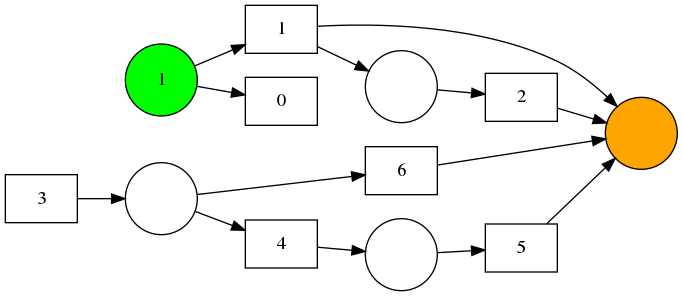

In [1]:
from pm4py.algo.discovery.alpha import factory as alpha_miner
from pm4py.objects.log.importer.xes import factory as xes_importer
from pm4py.visualization.petrinet import factory as vis_factory
log = xes_importer.import_log('event_log_task_ids.xes')
net, initial_marking, final_marking = alpha_miner.apply(log)
gviz = vis_factory.apply(net, initial_marking, final_marking)
vis_factory.view(gviz)

## Inductive Miner

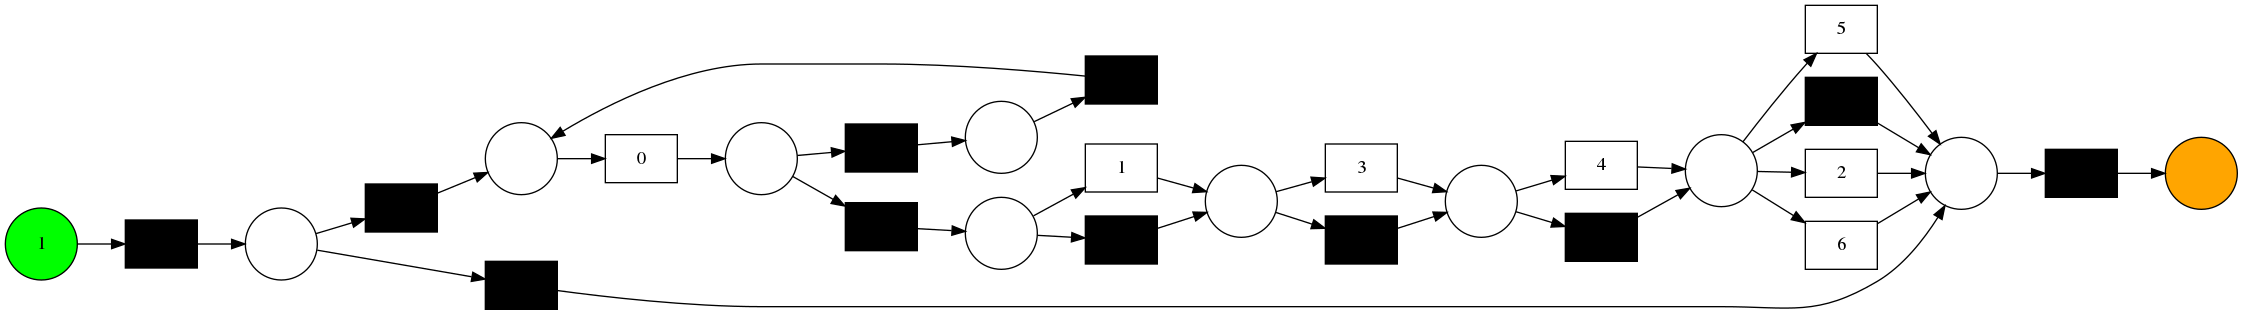

In [2]:
import os
from pm4py.objects.log.importer.xes import factory as xes_importer
from pm4py.algo.discovery.inductive import factory as inductive_miner
from pm4py.visualization.process_tree import factory as pt_vis_factory

og = xes_importer.import_log(os.path.join("event_log_task_ids.xes"))
net, initial_marking, final_marking = inductive_miner.apply(log)


gviz = vis_factory.apply(net, initial_marking, final_marking)
vis_factory.view(gviz)


## Heuristic Miner

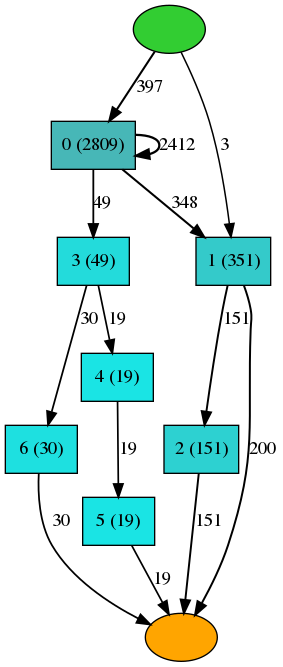

In [11]:
from pm4py.objects.log.importer.xes import factory as xes_importer
import os
log_path = os.path.join("event_log_task_ids.xes")
log = xes_importer.apply(log_path)

from pm4py.algo.discovery.heuristics import factory as heuristics_miner
heu_net = heuristics_miner.apply_heu(log, parameters={"dependency_thresh": 0.95})


from pm4py.visualization.heuristics_net import factory as hn_vis_factory
gviz = hn_vis_factory.apply(heu_net)
hn_vis_factory.view(gviz)